In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [10]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1. Create Data for Toy Problem

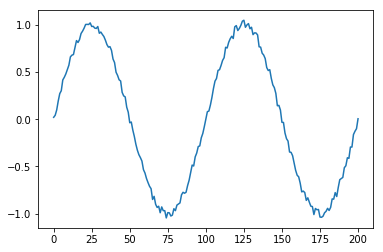

In [11]:
seed_int=123

rng = np.random.RandomState(seed_int)

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*rng.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 2a. Prepare Input Data to Train the Model

In [12]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 2b. Split Data into Training and Valdiation Set 

In [13]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation, random_state=seed_int)

# 3. Prepare Model Functions for Graph

In [14]:
def aweight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.Variable(initial, name=name)
    
def abias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)
    
def bias_variable(shape, name=None, init_fun=tf.zeros):
    initial = init_fun(shape, dtype=tf.float32)
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)

In [1]:

var_dict = {'IN': {'U': weight_variable([n_in, n_hidden], 'U_IN'),
                   'W': weight_variable([n_hidden, n_hidden], 'W_IN'),
                   'V': weight_variable([n_hidden, n_hidden], 'V_IN'),
                   'b': bias_variable([n_hidden], 'b_IN')},
            'OUT': {'U'} 


1

In [26]:

def infere_lstm(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('LSTM'):
        # going to combine this as (x, U)
        # INPUT UNITS
        Ui = weight_variable([n_in, n_hidden], 'Ui') 
        Wi = weight_variable([n_hidden, n_hidden], 'Wi')
        Vi = weight_variable([n_hidden, n_hidden], 'Vi')
        bi = bias_variable([n_hidden], 'bi')
        # OUTPUT UNITS
        Uo = weight_variable([n_in, n_hidden], 'Uo') 
        Wo = weight_variable([n_hidden, n_hidden], 'Wo')
        Vo = weight_variable([n_hidden, n_hidden], 'Vo')
        bo = bias_variable([n_hidden], 'bo')
        # FORGET UNITS
        Uf = weight_variable([n_in, n_hidden], 'Uf') 
        Wf = weight_variable([n_hidden, n_hidden], 'Wf')
        Vf = weight_variable([n_hidden, n_hidden], 'Vf')
        bf = bias_variable([n_hidden], 'bf', init_fun=tf.ones) # limit of the RNN is recovered for f=1, i.e. large bias
        # NEW MEMORY UNITS ('activation' units)
        Ua = weight_variable([n_in, n_hidden], 'Ua') 
        Wa = weight_variable([n_hidden, n_hidden], 'Wa')
        ba = bias_variable([n_hidden], 'ba')
        # Initialize lists
        hlist = []
        clist = []
      
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        c_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
                c_prev = clist[-1]
            a_i = tf.tanh(   tf.matmul(x[:, i, :], Ua) + tf.matmul(h_prev, Wa)                         + ba)
            f_i = tf.sigmoid(tf.matmul(x[:, i, :], Uf) + tf.matmul(h_prev, Wf) + tf.matmul(c_prev, Vf) + bf) 
            i_i = tf.sigmoid(tf.matmul(x[:, i, :], Ui) + tf.matmul(h_prev, Wi) + tf.matmul(c_prev, Vi) + bi) 
            c_i = i_i * a_i + f_i * c_prev
            o_i = tf.sigmoid(tf.matmul(x[:, i, :], Uo) + tf.matmul(h_prev, Wo) + tf.matmul(c_i, Vo)    + bo)
            h_i = o_i * tf.tanh(c_i)
            hlist.append(h_i)
            clist.append(c_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, c]

def loss_fun(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

def inference_LSTM(x, n_batch, maxlen=None, n_hidden=None, n_out=None, n_in=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('LSTM'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y, cell.variables


# 4. Define Graph

In [27]:
tf.reset_default_graph()

maxlen = 25
n_hidden = 4
n_out = 1
n_in = 1

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
#y = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
y, cvars = infere_lstm(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
loss = loss_fun(y, t)
train_step = training(loss)


# 5. Run Computational Graph

In [34]:
import time
start_time = time.time()

epochs = 1000
batch_size = 10

tf.set_random_seed(seed_int)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train, random_state = seed_int)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break
        
        
duration = time.time() - start_time
print(duration)

epoch: 0  validation loss:  0.571013
epoch: 1  validation loss:  0.557979
epoch: 2  validation loss:  0.534957
epoch: 3  validation loss:  0.481797
epoch: 4  validation loss:  0.358997
epoch: 5  validation loss:  0.310978
epoch: 6  validation loss:  0.288545
epoch: 7  validation loss:  0.267368
epoch: 8  validation loss:  0.252772
epoch: 9  validation loss:  0.239325
epoch: 10  validation loss:  0.224776
epoch: 11  validation loss:  0.209943
epoch: 12  validation loss:  0.195594
epoch: 13  validation loss:  0.181874
epoch: 14  validation loss:  0.168761
epoch: 15  validation loss:  0.156318
epoch: 16  validation loss:  0.144654
epoch: 17  validation loss:  0.133834
epoch: 18  validation loss:  0.123867
epoch: 19  validation loss:  0.114725
epoch: 20  validation loss:  0.106361
epoch: 21  validation loss:  0.0987164
epoch: 22  validation loss:  0.0917261
epoch: 23  validation loss:  0.0853267
epoch: 24  validation loss:  0.0794609
epoch: 25  validation loss:  0.07408
epoch: 26  validati

epoch: 207  validation loss:  0.0017026
epoch: 208  validation loss:  0.0016974
epoch: 209  validation loss:  0.00169227
epoch: 210  validation loss:  0.0016872
epoch: 211  validation loss:  0.00168219
epoch: 212  validation loss:  0.00167724
epoch: 213  validation loss:  0.00167235
epoch: 214  validation loss:  0.00166751
epoch: 215  validation loss:  0.00166274
epoch: 216  validation loss:  0.00165801
epoch: 217  validation loss:  0.00165334
epoch: 218  validation loss:  0.00164873
epoch: 219  validation loss:  0.00164416
epoch: 220  validation loss:  0.00163964
epoch: 221  validation loss:  0.00163517
epoch: 222  validation loss:  0.00163075
epoch: 223  validation loss:  0.00162637
epoch: 224  validation loss:  0.00162204
epoch: 225  validation loss:  0.00161775
epoch: 226  validation loss:  0.00161351
epoch: 227  validation loss:  0.0016093
epoch: 228  validation loss:  0.00160514
epoch: 229  validation loss:  0.00160101
epoch: 230  validation loss:  0.00159693
epoch: 231  validati

epoch: 409  validation loss:  0.00116642
epoch: 410  validation loss:  0.00116485
epoch: 411  validation loss:  0.00116327
epoch: 412  validation loss:  0.00116168
epoch: 413  validation loss:  0.00116008
epoch: 414  validation loss:  0.00115848
epoch: 415  validation loss:  0.00115686
epoch: 416  validation loss:  0.00115523
epoch: 417  validation loss:  0.0011536
epoch: 418  validation loss:  0.00115195
epoch: 419  validation loss:  0.0011503
epoch: 420  validation loss:  0.00114864
epoch: 421  validation loss:  0.00114697
epoch: 422  validation loss:  0.00114529
epoch: 423  validation loss:  0.0011436
epoch: 424  validation loss:  0.00114191
epoch: 425  validation loss:  0.00114021
epoch: 426  validation loss:  0.0011385
epoch: 427  validation loss:  0.00113679
epoch: 428  validation loss:  0.00113506
epoch: 429  validation loss:  0.00113333
epoch: 430  validation loss:  0.0011316
epoch: 431  validation loss:  0.00112985
epoch: 432  validation loss:  0.0011281
epoch: 433  validation

epoch: 609  validation loss:  0.000955519
epoch: 610  validation loss:  0.000955402
epoch: 611  validation loss:  0.000955287
epoch: 612  validation loss:  0.000955171
epoch: 613  validation loss:  0.000955061
epoch: 614  validation loss:  0.000954948
epoch: 615  validation loss:  0.000954836
epoch: 616  validation loss:  0.000954725
epoch: 617  validation loss:  0.000954617
epoch: 618  validation loss:  0.000954506
epoch: 619  validation loss:  0.000954399
epoch: 620  validation loss:  0.000954293
epoch: 621  validation loss:  0.000954187
epoch: 622  validation loss:  0.000954077
epoch: 623  validation loss:  0.000953975
epoch: 624  validation loss:  0.000953869
epoch: 625  validation loss:  0.000953765
epoch: 626  validation loss:  0.000953661
epoch: 627  validation loss:  0.000953558
epoch: 628  validation loss:  0.000953457
epoch: 629  validation loss:  0.000953352
epoch: 630  validation loss:  0.00095325
epoch: 631  validation loss:  0.000953147
epoch: 632  validation loss:  0.000

epoch: 805  validation loss:  0.000930491
epoch: 806  validation loss:  0.000930336
epoch: 807  validation loss:  0.000930184
epoch: 808  validation loss:  0.000930029
epoch: 809  validation loss:  0.000929876
epoch: 810  validation loss:  0.000929721
epoch: 811  validation loss:  0.000929569
epoch: 812  validation loss:  0.000929415
epoch: 813  validation loss:  0.000929264
epoch: 814  validation loss:  0.000929111
epoch: 815  validation loss:  0.000928958
epoch: 816  validation loss:  0.000928807
epoch: 817  validation loss:  0.000928657
epoch: 818  validation loss:  0.000928508
epoch: 819  validation loss:  0.000928353
epoch: 820  validation loss:  0.000928203
epoch: 821  validation loss:  0.000928055
epoch: 822  validation loss:  0.000927905
epoch: 823  validation loss:  0.000927758
epoch: 824  validation loss:  0.000927609
epoch: 825  validation loss:  0.00092746
epoch: 826  validation loss:  0.000927316
epoch: 827  validation loss:  0.000927168
epoch: 828  validation loss:  0.000

# 6. Show Results

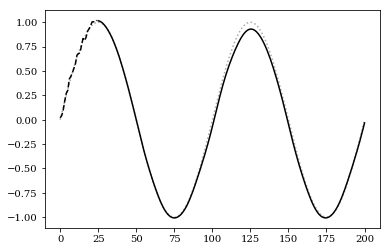

In [35]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# 7. Inspect Variables

#### What happened to the variables in RNN cell?

In [14]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)

(20, 1)
(1, 20)


In [15]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='RNN')

[<tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=float32_ref>]

In [16]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'V:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'V/Adam:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'V/Adam_1:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c/Adam:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'c/Adam_1:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=fl